<a href="https://colab.research.google.com/github/jeonghojo00/ImageCaptioning/blob/main/0_ImgCaptioning_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing
Before running training, images and captions are needed to be preprocessed.
1. Captions ared needed to be changed to lowercase and tokenized </br>
   1.1. These captions are also used for making a vocabulary dicitonary for caption generations </br>
2. Images are needed to be loaded, changed to RGB array, calculated for means and standard deviation, then normalized.  </br>

## DataLoading

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change directory to the package folder
%cd '/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/'
# Verify the contents of the current folder
!ls

/content/drive/MyDrive/Colab Notebooks/ImageCaptioning
captions_val2014_fakecap_results.json  inception.py	__pycache__
captions_val2014.json		       inf_result.pkl	resize_image.py
checkpoint			       learned_models	resnet.py
code				       load_data.py	show_attend_tell.py
cs7643-final-project		       lstm_decoder.py	split_caption.py
data				       main.py		util
data_loader.py			       model		utils.py
efficientnet.py			       models		vgg.py
eval.pkl			       models.py	vocab.pkl
experiments			       pretraining.py	vocabulary.py


In [3]:
import os
import pandas as pd
from tqdm import tqdm

### Resize Images
Resize images to speedup training and split into train, valid, and test images

In [4]:
def resize_image(image, size):
    # Resize image size
    return image.resize(size, Image.ANTIALIAS)

Image Name:  391106734_d374bc3080.jpg
Image Shape:  (500, 354, 3)


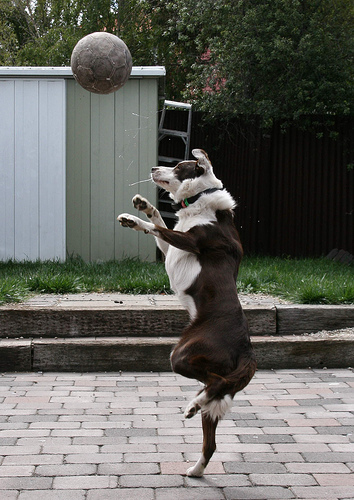

In [7]:
# Load an image
from PIL import Image
import numpy as np

image_dir = './data/flickr8k/Images' # Original images folder
image_name = os.listdir(image_dir)[0]
img_path = os.path.join(image_dir, image_name)
print("Image Name: ", image_name)

img = Image.open(img_path).convert('RGB')
img_np = np.array(img)
print("Image Shape: ", img_np.shape)
img

Resized Image Shape:  (256, 256, 3)


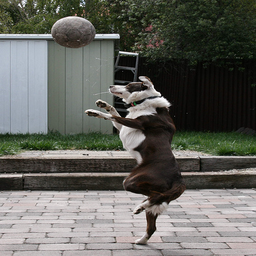

In [8]:
# Resize the image
resize_size=[256,256]
resized_img = resize_image(img, resize_size)
img_np = np.array(resized_img)
print("Resized Image Shape: ", img_np.shape)
resized_img

## Preprocess Captions

### Tokenize captions

In [65]:
from split_caption import *
from collections import Counter

In [66]:
caption_path = './data/flickr8k/captions.txt' # Original caption file with path
num_train_images = 6000
num_val_images = 1000

In [67]:
with open(caption_path, "r") as f:
    lines = sorted(f.readlines()[1:])

In [68]:
counter = Counter()
line = lines[0]
print("0. First line in the caption file")
print(line)
index = line.find(",")
caption = line[index + 1:]
print("1. Caption text of the first line")
print(caption)
tokens = nltk.tokenize.word_tokenize(caption.lower())
print("2. Tokenize the caption after chaning to lowercase")
print(tokens)
counter.update(tokens) # Count number of tokens occurred in a caption
print("\n3. An example of counter for Vocabulary")
print(counter)

0. First line in the caption file
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .

1. Caption text of the first line
A child in a pink dress is climbing up a set of stairs in an entry way .

2. Tokenize the caption after chaning to lowercase
['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.']

3. An example of counter for Vocabulary
Counter({'a': 3, 'in': 2, 'child': 1, 'pink': 1, 'dress': 1, 'is': 1, 'climbing': 1, 'up': 1, 'set': 1, 'of': 1, 'stairs': 1, 'an': 1, 'entry': 1, 'way': 1, '.': 1})


### Make Vocabulary

In [69]:
# Through the loop over the caption, make a counter for Vocabulary data
with open(caption_path, "r") as f:
    lines = sorted(f.readlines()[1:])
    for i in range(len(lines)):
        line = lines[i]
        index = line.find(",") # Find where "," locates to splite the caption and image file name
        caption = line[index + 1:] # Extract the caption
        tokens = nltk.tokenize.word_tokenize(caption.lower()) # Tokenize captions
        counter.update(tokens) # Count number of tokens occurred in a caption

In [76]:
print("First 5 items in the counter, (word, number of occurances")
iterator = iter(counter.items())
for i in range(5):
    print(next(iterator))

First 5 items in the counter, (word, number of occurances
('a', 62989)
('child', 1546)
('in', 18976)
('pink', 736)
('dress', 349)


In [78]:
# Make a list of words that occur more than the number assigned for word_threshold
# Ex) if "disney" occurs twice in the caption file and word_threshold is 3, the word "disney" is not included in the words list
word_threshold = 4
words = [word for word, cnt in counter.items() if cnt >= word_threshold]
print(words[0:5])

['a', 'child', 'in', 'pink', 'dress']


In [49]:
# Initialize Vocabuliary class
vocab = Vocabulary()

vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>') # unknown token
print(vocab.word2idx)

{'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}


In [80]:
# add word into Vocabulary
for word in words:
    vocab.add_word(word)
print("First 5 items in vocab.word2idx, (word, index")
iterator = iter(vocab.word2idx.items())
for i in range(10):
    print(next(iterator))

First 5 items in vocab.word2idx, (word, index
('<pad>', 0)
('<start>', 1)
('<end>', 2)
('<unk>', 3)
('a', 4)
('child', 5)
('in', 6)
('pink', 7)
('dress', 8)
('is', 9)


## Image Transformation for Training, Validation, and Testing

In [61]:
from torchvision import transforms

crop_size = 224 # Image size to crop. 299 if encoder=="InceptionV3"

train_transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

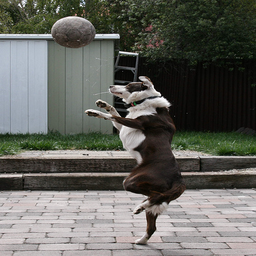

In [62]:
resized_img

Shape of Image after transforms:  torch.Size([3, 224, 224])


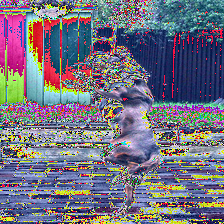

In [63]:
# For training, use random horizontal flip
tr_img = train_transform(resized_img)
print("Shape of Image after transforms: ", tr_img.shape)
to_pil = transforms.ToPILImage()
tr_image_display = to_pil(tr_img)

tr_image_display

Shape of Image after transforms:  torch.Size([3, 224, 224])


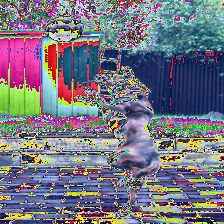

In [64]:
# For validation and testing.
val_img = val_transform(resized_img)
print("Shape of Image after transforms: ", val_img.shape)
to_pil = transforms.ToPILImage()
val_image_display = to_pil(val_img)

val_image_display